# Cut-off Value



## 0.환경준비

### 0.1 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.2 데이터 로딩

In [2]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/titanic.1.csv"
data = pd.read_csv(path, usecols = ['Survived', 'Sex','Pclass','Age','Fare','Embarked','Family'])
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


## 1.데이터 탐색

## 2.데이터 준비


### 2.1 x, y로 나누기 

In [3]:
target = 'Survived'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2.2 가변수화

In [4]:
dummy_cols = ['Pclass', 'Sex', 'Embarked']
x = pd.get_dummies(data = x, columns = dummy_cols, drop_first = True)
x.head()

,Age,Fare,Family,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,22.0,7.2500,2,0,1,1,0,1
1,38.0,71.2833,2,0,0,0,0,0
2,26.0,7.9250,1,0,1,0,0,1
3,35.0,53.1000,2,0,0,0,0,1
4,35.0,8.0500,1,0,1,1,0,1


### 2.3 train : validation 분할

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 2022)

In [7]:
x_train.shape

(623, 8)

## 3.모델링

In [8]:
# 필요한 라이브러리, 함수들을 불러옵시다.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [10]:
model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)

LogisticRegression(max_iter=500)

* .predict_proba 로 예측하면, **각 클래스별 확률값**으로 반환됩니다.

In [11]:
pred = model.predict_proba(x_val)
pred[:5]

array([[0.87237948, 0.12762052],
       [0.69505522, 0.30494478],
       [0.32451013, 0.67548987],
       [0.94494376, 0.05505624],
       [0.90782696, 0.09217304]])

* 0의 확률 + 1의 확률 = 1 이므로, 둘 중 하나(1의 확률)만 사용합시다. 

In [12]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({ 'predicted': pred[:, 1], 'actual': y_val.values})

## 4.Cut-off 조절

### 4.1 Cut-off 조절하며 성능 평가결과 저장

* np.linspace(시작값, 끝값, 갯수)  
https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

In [13]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [14]:
# 결과를 저장할 빈 리스트
acc, rec, prec = [],[],[] 

# 0부터 1까지 cutoff값을 조금씩 증가시키며, 성능 평가결과 저장
cutoff_values = np.linspace(0, 1, 200)

for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    result['predict01'] = np.where(result['predicted']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], result['predict01']))
    rec.append(recall_score(result['actual'], result['predict01'], pos_label = 1))
    prec.append(precision_score(result['actual'], result['predict01'], pos_label = 1))


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is i

### 4.2 cut off에 따른 성능 평가 그래프

#### 1) cut-off를 조절하면서 Accuracy, Recall, Precision 그래프 그려봅시다.

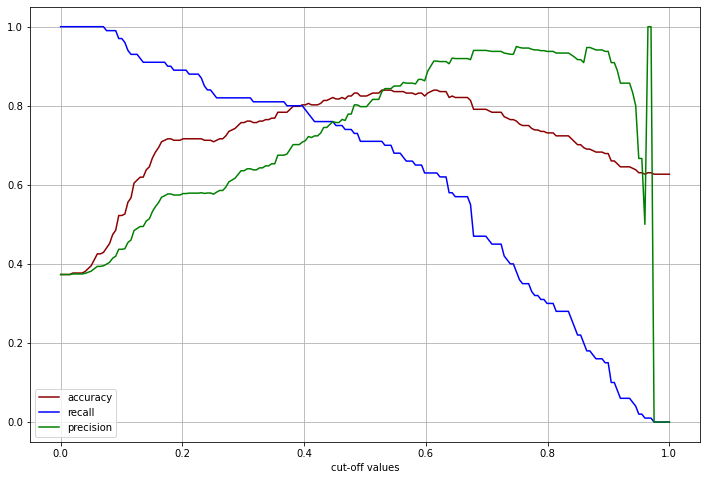

In [15]:
# cut off에 따른 성능 평가 그래프를 그려봅시다.
plt.figure(figsize = (12,8))
plt.plot(cutoff_values, acc, label = 'accuracy', color = 'darkred')
plt.plot(cutoff_values, rec, label = 'recall', color = 'blue')
plt.plot(cutoff_values, prec, label = 'precision', color = 'green')

plt.xlabel('cut-off values')
plt.legend()
plt.grid()
plt.show()

* 위 그래프를 보면, recall과 precision이 서로 trade-off 관계라는 것을 알 수 있습니다.
* Accuracy 최대값과 그때의 cutoff는 어떻게 찾을까요?

In [16]:
# acc의 최대값
max(acc)

0.8395522388059702

In [17]:
# acc가 최대값일 때의 cutoff
print(f'acc가 최대값일 때의 index : {np.argmax(acc)}')
print(f'그때의 cutoff : {cutoff_values[np.argmax(acc)]}')

acc가 최대값일 때의 index : 105
그때의 cutoff : 0.5276381909547738


* 그래서 위에서 찾은 값을 그래프에 표현해 봅시다.

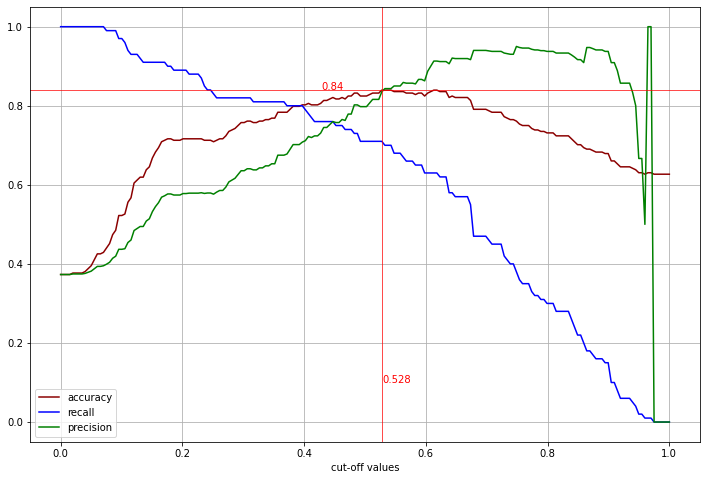

In [18]:
# cut off에 따른 성능 평가 그래프를 그려봅시다.
plt.figure(figsize = (12,8))
plt.plot(cutoff_values, acc, label = 'accuracy', color = 'darkred')
plt.plot(cutoff_values, rec, label = 'recall', color = 'blue')
plt.plot(cutoff_values, prec, label = 'precision', color = 'green')

# Accuracy를 최대화 해주는 cut off를 수평/수직선으로 표시
max_acc_cut = round(cutoff_values[np.argmax(acc)],3)
max_acc = round(max(acc),3)

plt.axvline(max_acc_cut, color = 'r', linewidth = .7)
plt.text(max_acc_cut, .1, max_acc_cut, color = 'r')

plt.axhline(max_acc, color = 'r', linewidth = .7)
plt.text(max_acc_cut -.1, max_acc, max_acc, color = 'r')

plt.xlabel('cut-off values')
plt.legend()
plt.grid()
plt.show()

#### 2) precision - recall curve

* 모델을 평가할 때 cutoff와 상관 없이 전반적인 평가를 하는 방법은, cutoff를 조금씩 조절하면서 그린 성능 curve로 비교하고 평가하는 것입니다.
* 대표적인 두가지가 있습니다.
    * AUROC : 민감도, 1-특이도 곡선 (**실제값 관점에서 모델 성능**)
    * Precision-Recall Curve (**Class 0 혹은 1 관점에서 모델의 성능**)
* 둘 다 cuve 아래 **면적**으로 비교하게 됩니다.
* 여기서는 Precision-Recall Curve 만을 다뤄봅니다.

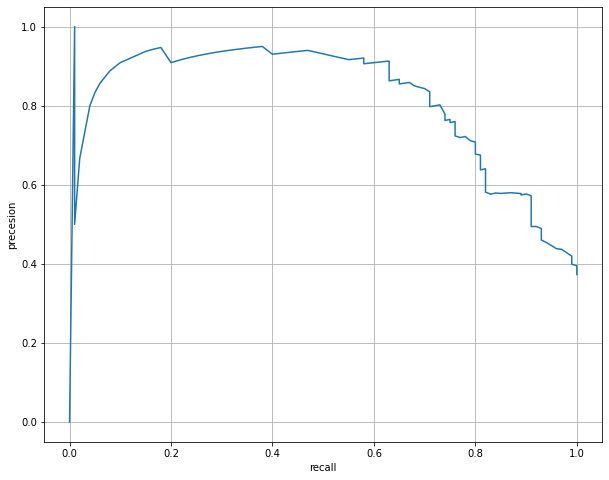

In [19]:
# precision - recall curve
plt.figure(figsize = (10,8))
plt.plot(rec, prec)

plt.xlabel('recall')
plt.ylabel('precesion')

plt.grid()
plt.show()

#### 3) sklearn에서 제공되는 함수들

* precision_recall_curve(실제값, 예측값_확률)

In [20]:
precision, recall, threshold = precision_recall_curve(y_val, result['predicted'])

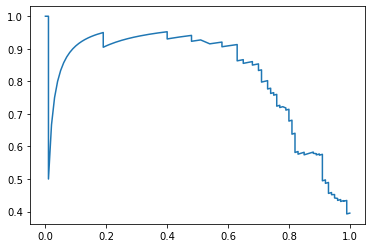

In [22]:
plt.plot(recall, precision)

* plot_precision_recall_curve(모델, x_val, y_val)
    * AP : Curve 아래 면적

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_precision_recall_curve.html

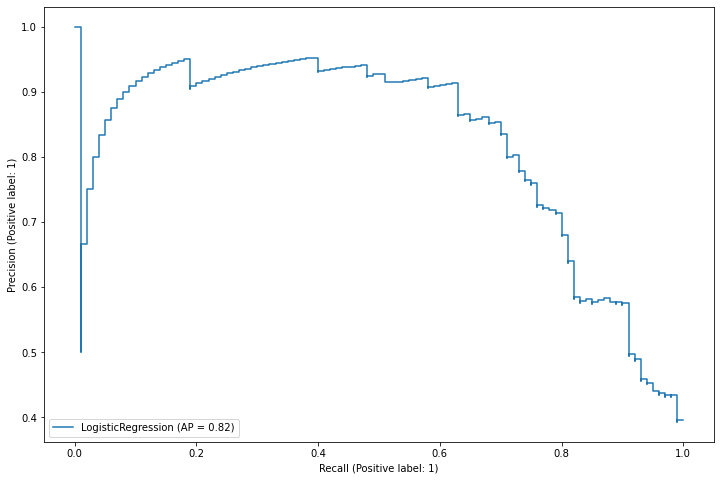

In [21]:
# precision - recall curve
plt.figure(figsize = (12,8))
pr_curve = plot_precision_recall_curve(model, x_val, y_val, ax = plt.gca())
plt.show()

# ax = plt.gca() 옵션은, plt.#### 함수들을 함께 사용할 수 있게 해줍니다.

plot_precision_recall_curve의 결과를 저장하고  
.average_precision 속성을 불러오면, 계산된 아래 면적을 알 수 있습니다.

In [23]:
pr_curve.average_precision

0.8199753400362151

## 5.실습

> * 기본 실습문제를 풀며, 주어진 코드와 결과를 이해하는데 집중하세요.
* 혹시 시간 여유가 된다면, 심화 문제를 풀어봅시다.(옵션)
    * 심화문제는 강사가 풀이를 할 예정입니다.

### 5.1 기본실습 

* 다음 알고리즘 중 하나를 선정하여 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 3)
    * Random Forest()

* 모델에 대해서 
    * .predict_proba 로 예측 결과를 저장하시오.
    * cutoff를 0부터 1사이에서 0.01씩 증가시키면서 Accuracy curve를 그려봅시다.
    * Accuracy 최대값, 그때의 cutoff를 찾아 봅시다. 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [26]:
m1 = LogisticRegression(max_iter=500)

m1.fit(x_train, y_train)

LogisticRegression(max_iter=500)

* .predict_proba로 예측
* 1일 확률값만 저장하기

In [27]:
pred1 = m1.predict_proba(x_val)

pred1[:5]

array([[0.87237948, 0.12762052],
       [0.69505522, 0.30494478],
       [0.32451013, 0.67548987],
       [0.94494376, 0.05505624],
       [0.90782696, 0.09217304]])

* 예측결과와 실제 결과를 데이터프레임으로 저장

In [30]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({'pred1':pred1[:, 1], 'actual':y_val.values})

* cutoff 조절하며 accuracy score

In [31]:
# 결과를 저장할 빈 리스트
acc = []

# 0부터 1까지 cutoff값을 조금씩 증가시키며, 성능 평가결과 저장
cutoff_values = np.linspace(0, 1, 200)

for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    pred_01 = np.where(result['pred1']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], pred_01))

* Accuracy Curve 그리기

0.5276381909547738 0.8395522388059702


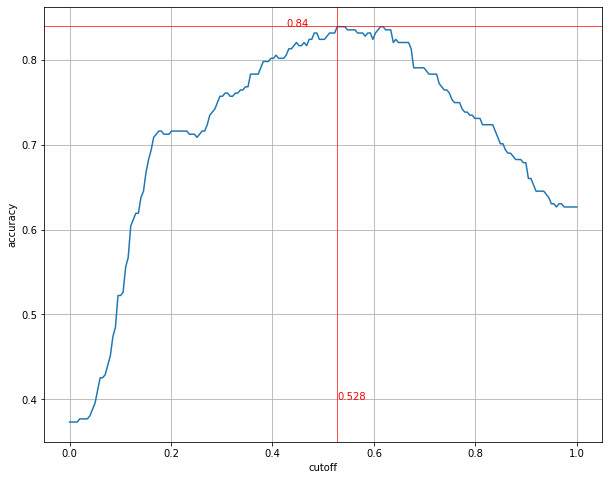

In [32]:
# Accuracy Curve

print(cutoff_values[np.argmax(acc)], max(acc))

plt.figure(figsize = (10,8))
plt.plot(cutoff_values, acc)

max_acc_cut = round(cutoff_values[np.argmax(acc)],3)
max_acc = round(max(acc),3)

plt.axvline(max_acc_cut, color = 'r', linewidth = .7)
plt.text(max_acc_cut, .4, max_acc_cut, color = 'r')

plt.axhline(max_acc, color = 'r', linewidth = .7)
plt.text(max_acc_cut -.1, max_acc, max_acc, color = 'r')

plt.xlabel('cutoff')
plt.ylabel('accuracy')

plt.grid()
plt.show()

### 5.2 심화실습1 

* 다음 알고리즘에 대해 각각 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 3)
    * Random Forest()

* 각 모델에 대해서 
    * .predict_proba 로 예측 결과를 저장하시오.
    * cutoff를 0부터 1사이에서 0.01씩 증가시키면서 Accuracy curve를 그려봅시다.
    * Accuracy 최대값, 그때의 cutoff를 찾아 봅시다. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [33]:
m2 = DecisionTreeClassifier(max_depth=3, random_state=2022)

m2.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=2022)

* .predict_proba로 예측

In [34]:
pred2 = m2.predict_proba(x_val)

pred2[:5]

array([[0.89605735, 0.10394265],
       [0.89605735, 0.10394265],
       [0.44594595, 0.55405405],
       [0.9       , 0.1       ],
       [0.89605735, 0.10394265]])

* 예측결과와 실제 결과를 데이터프레임으로 저장

In [35]:
result['pred2'] = pred2[:, 1]

* cutoff 조절하며 accuracy score

In [36]:
acc = []

# 0부터 1까지 cutoff값을 조금씩 증가시키며, 성능 평가결과 저장
cutoff_values = np.linspace(0, 1, 200)

for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    pred_02 = np.where(result['pred2']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], pred_02))

0.33668341708542715 0.832089552238806


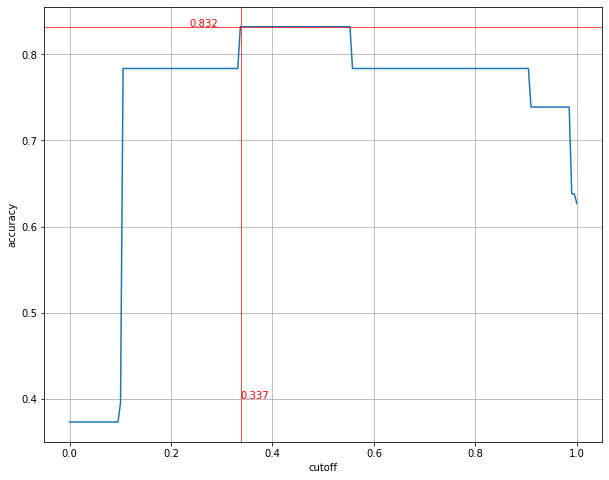

In [37]:
# Accuracy Curve

print(cutoff_values[np.argmax(acc)], max(acc))

plt.figure(figsize = (10,8))
plt.plot(cutoff_values, acc)

max_acc_cut = round(cutoff_values[np.argmax(acc)],3)
max_acc = round(max(acc),3)

plt.axvline(max_acc_cut, color = 'r', linewidth = .7)
plt.text(max_acc_cut, .4, max_acc_cut, color = 'r')

plt.axhline(max_acc, color = 'r', linewidth = .7)
plt.text(max_acc_cut -.1, max_acc, max_acc, color = 'r')

plt.xlabel('cutoff')
plt.ylabel('accuracy')

plt.grid()
plt.show()

### 5.3 심화실습2

* 다음 알고리즘으로 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 3)
    * Random Forest()

* 세 모델의 성능비고 : Precision-Recall Curve와 Average Precision로 성능을 비교합시다.


In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
m3 = RandomForestClassifier(random_state=2022)

m3.fit(x_train, y_train)

RandomForestClassifier(random_state=2022)

* .predict_proba로 예측

In [41]:
pred3 = m3.predict_proba(x_val)

pred3[:5]

array([[0.91, 0.09],
       [0.96, 0.04],
       [0.74, 0.26],
       [0.83, 0.17],
       [1.  , 0.  ]])

In [42]:
result['pred3'] = pred3[:, 1]

In [46]:
acc = []

cutoff_values = np.linspace(0, 1, 200)

for i in cutoff_values :
    # cutoff로 0과 1로 바꾸기
    pred_03 = np.where(result['pred3'] > i, 1, 0)
    
    # 평가지표 저장
    acc.append(accuracy_score(result['actual'], pred_03))


0.6834170854271356 0.8208955223880597


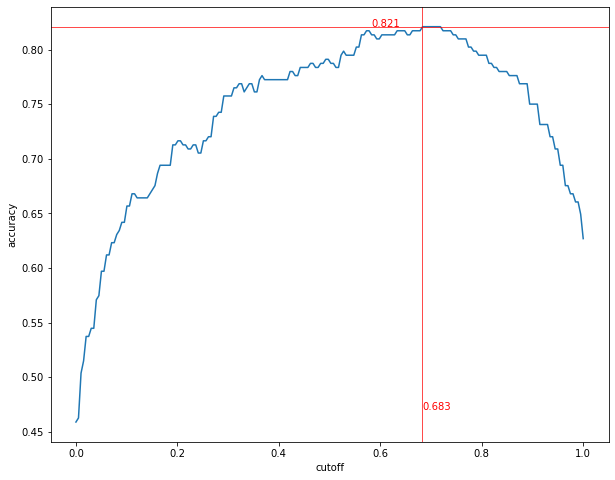

In [60]:
print(cutoff_values[np.argmax(acc)], max(acc))

plt.figure(figsize=(10,8))
plt.plot(cutoff_values, acc)

max_acc_cut = round(cutoff_values[np.argmax(acc)], 3)
max_acc = round(max(acc), 3)

plt.axvline(max_acc_cut, color='r', linewidth=.7)
plt.text(max_acc_cut, .47, max_acc_cut, color='r')

plt.axhline(max_acc, color='r', linewidth=.7)
plt.text(max_acc_cut -.1, max_acc, max_acc, color='r')

plt.xlabel('cutoff')
plt.ylabel('accuracy')

plt.show()

In [61]:
def acc_plot(accuricy_list, cutoff_list) :
    print(cutoff_values[np.argmax(accuricy_list)], max(accuricy_list))

    plt.figure(figsize=(10,8))
    plt.plot(cutoff_list, accuricy_list)

    max_acc_cut = round(cutoff_list[np.argmax(accuricy_list)], 3)
    max_acc = round(max(accuricy_list), 3)

    plt.axvline(max_acc_cut, color='r', linewidth=.7)
    plt.text(max_acc_cut, .47, max_acc_cut, color='r')

    plt.axhline(max_acc, color='r', linewidth=.7)
    plt.text(max_acc_cut -.1, max_acc, max_acc, color='r')

    plt.xlabel('cutoff')
    plt.ylabel('accuracy')

    plt.show()

0.6834170854271356 0.8208955223880597


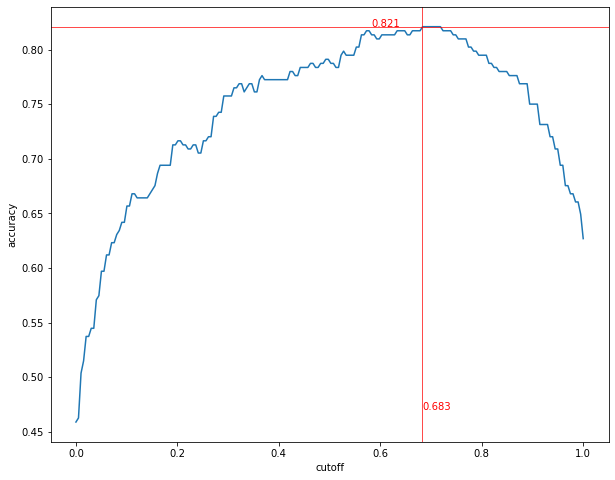

In [62]:
acc_plot(acc, cutoff_values)

### 6. ROC 그래프 그리기

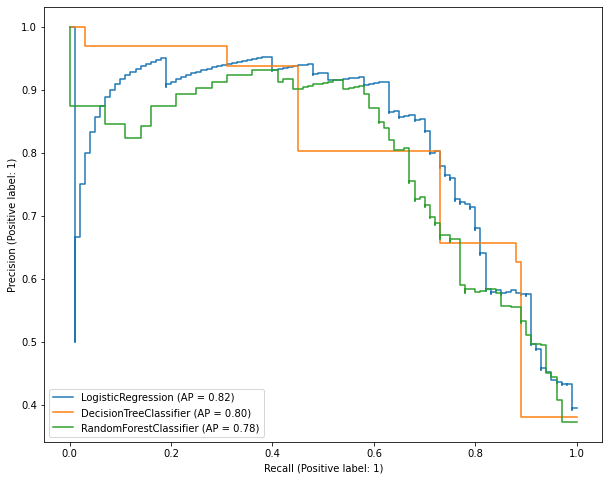

In [64]:
plt.figure(figsize=(10,8))

ax1 = plot_precision_recall_curve(m1, x_val, y_val, ax = plt.gca())
ax2 = plot_precision_recall_curve(m2, x_val, y_val, ax = plt.gca())
ax3 = plot_precision_recall_curve(m3, x_val, y_val, ax = plt.gca())

plt.show()

In [65]:
print(ax1.average_precision)
print(ax2.average_precision)
print(ax3.average_precision)

0.8199753400362151
0.8038751857601822
0.7817055117416769
